In [1]:
import os
import pickle as pkl
import sys

import numpy as np
import random as rn
import argparse
from itertools import count
from collections import defaultdict

import torch
from torch.utils.data import Dataset, DataLoader
import torch.nn as nn

import pandas as pd
from matplotlib import pyplot as plt

from sklearn.model_selection import GridSearchCV
from sklearn.svm import LinearSVC, SVC
from sklearn.metrics import precision_recall_fscore_support, accuracy_score
from sklearn.metrics import precision_recall_fscore_support, accuracy_score
from sklearn import preprocessing

from tqdm import tqdm
np.set_printoptions(threshold=sys.maxsize)
from imblearn.over_sampling import SMOTE

## Fix random seeds for reproducibility

In [2]:
os.environ['PYTHONHASHSEED'] = '0'
np.random.seed(12456)
rn.seed(12345)
torch.manual_seed(1234)

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

## Tools

In [3]:
# Load labels from CSV file
def load_labels(files):

	train_labels = files[0]
	devel_labels = files[1]
	
	y_train = pd.read_csv(train_labels, sep=',')['label'].values
	y_devel = pd.read_csv(devel_labels, sep=',')['label'].values
	
	return y_train, y_devel



# Load data from CSV file
def load_data(files):
	train_file = files[0]
	devel_file = files[1]
	test_file  = files[2]
	
	X_train = pd.read_csv(train_file, header=None, index_col=False, sep=';').values
	X_devel = pd.read_csv(devel_file, header=None, index_col=False, sep=';').values
	X_test  = pd.read_csv(test_file, header=None, index_col=False, sep=';').values
	
	return X_train, X_devel, X_test


# Saves predictions
def save_predictions(file_list_path, predictions, output_path):
	files = pd.read_csv(file_list_path)
	file_ids = files.file_id.values
	pred_df = pd.DataFrame({'file_id': file_ids, 'predictions': predictions})
	pred_df.to_csv(output_path, index=False)


# plot training history
def plot_training_history(epochs, plottable, ylabel='', name=''):
	plt.clf()
	plt.xlabel('Epoch')
	plt.ylabel(ylabel)
	if len(plottable) == 1:
		plt.plot(np.arange(epochs), plottable[0], label='Loss')
	elif len(plottable) == 2:
		plt.plot(np.arange(epochs), plottable[0], label='Acc')
		plt.plot(np.arange(epochs), plottable[1], label='UAR')
	else:
		raise ValueError('plottable passed to plot function has incorrect dim.')
	plt.legend()
	plt.savefig('%s.png' % (name), bbox_inches='tight')


## Dirs

In [4]:
directory = "." # Full path to your current folder
# Label files
labels_train = "../lab3_part1/corpus/labels/train_labels.csv"
labels_devel = "../lab3_part1/corpus/labels/dev_labels.csv"
test_list_path = "../lab3_part1/corpus/labels/test_file_list.txt"

label_files = [labels_train, labels_devel]

## Part 3

In [5]:
class SleepinessDataset(Dataset):
    def __init__(self, data_files, label_files):
        # # Load data and labels
        X_train, X_dev, X_test = load_data(data_files)
        y_train, y_dev = load_labels(label_files)
        
        ##over sampling
        sm = SMOTE(random_state=12345)
        X_train_res, y_train_res = sm.fit_resample(X_train, y_train)
        
        self.X = torch.tensor(X_train_res, dtype=torch.float).to(device)
        self.y = torch.tensor(y_train_res, dtype=torch.long).to(device)

        self.dev_X = torch.tensor(X_dev, dtype=torch.float).to(device)
        self.dev_y = torch.tensor(y_dev, dtype=torch.long).to(device)

        self.test_X = torch.tensor(X_test, dtype=torch.float).to(device)


    def __len__(self):
        return len(self.X)

    def __getitem__(self, idx):
        return self.X[idx], self.y[idx]

In [6]:
class FeedforwardNetwork(nn.Module):
    def __init__(
        self, n_classes, n_features, dropout, hidden_size, **kwargs):
        '''
        This function initializes the network. It defines its architecture.
            - n_classes (int): number of classes. In this problem it will be 2
            - n_features (int): number of features
            - dropout (float): dropout probability
        '''
        super(FeedforwardNetwork, self).__init__()

        torch.manual_seed(1234)
        self.lin1 = nn.Sequential(
            nn.Linear(n_features, hidden_size), 
            nn.BatchNorm1d(hidden_size),
            nn.ReLU(),
            nn.Dropout(dropout)
            )

        torch.manual_seed(1234)
        self.lin2 = nn.Sequential(
            nn.Linear(hidden_size, hidden_size), 
            nn.BatchNorm1d(hidden_size),
            nn.ReLU(),
            nn.Dropout(dropout)
            )
        
        torch.manual_seed(1234)
        self.lin3 = nn.Sequential(
            nn.Linear(hidden_size, hidden_size), 
            nn.BatchNorm1d(hidden_size),
            nn.ReLU(),
            nn.Dropout(dropout)
            )

        # for classification tasks you should use a softmax as final
        # activation layer, but if you use the loss function
        # nn.CrossEntropyLoss() as we are using in this lab, you do
        # not need to compute it explicitly
        torch.manual_seed(1234)
        self.lin_out = nn.Linear(hidden_size, n_classes)
        
    def forward(self, x, **kwargs):
        """
        This function corresponds to the forward pass, which means
        that the input is being propagated through the network, layer
        by layer.
        - x (batch_size x n_features): a batch of training examples
        """

        output = self.lin1(x)
        output = self.lin2(output)
        output = self.lin3(output)
        output = self.lin_out(output)

        return output


In [7]:
def train_batch(X, y, model, optimizer, criterion, **kwargs):
    """
    X (n_examples x n_features)
    y (n_examples): gold labels
    model: a PyTorch defined model
    optimizer: optimizer used in gradient step
    criterion: loss function
    """

    model.train()

    # zero the parameter gradients
    optimizer.zero_grad()

    # forward step
    outputs = model.forward(X);

    loss = criterion(outputs, y)

    # propagate loss backward
    loss.backward()

    # updtate the weights
    optimizer.step()

    return loss


def predict(model, X):
    """X (n_examples x n_features)"""
    model.eval()
    # make the predictions
    scores = model.forward(X)

    # scores contains, for each example, two scores that can be interpreted as the
    # probability of each example belonging to each of the classes. To select the
    # final predicted label, we will select the class with higher probability.
    predicted_labels = scores.argmax(dim=-1)  # predicted_labels shape: (n_examples)

    return predicted_labels


def evaluate(model, X, y):
    """
    X (n_examples x n_features)
    y (n_examples): labels
    """
    model.eval()

    # make the predictions
    y_hat = predict(model, X)

    # convert to cpu
    y_hat = y_hat.detach().cpu()
    y = y.detach().cpu()

    # compute evaluation metrics
    accuracy = accuracy_score(y, y_hat)
    prf 	 = precision_recall_fscore_support(y, y_hat, labels=[0,1], average='macro')

    return accuracy, prf


def train(dataset, model, optimizer, criterion, batch_size, epochs):
    train_dataloader = DataLoader(
        dataset, batch_size=batch_size, shuffle=True)

    dev_X, dev_y = dataset.dev_X, dataset.dev_y

    epochs = torch.arange(1, epochs + 1)
    train_mean_losses = []
    valid_accs = []
    train_losses = []
    valid_uar = []

    for ii in epochs:
        print('Training epoch {}'.format(ii))
        for X_batch, y_batch in train_dataloader:

            # train each batch:
            loss = train_batch(X_batch, y_batch, model, optimizer, criterion)
            train_losses.append(loss)

        mean_loss = torch.tensor(train_losses).mean().item()
        print('Training loss: %.4f' % (mean_loss))

        train_mean_losses.append(mean_loss)

        # at the end of each epoch, evaluate with the dev set:
        val_accuracy, val_prf = evaluate(model, dev_X, dev_y)

        valid_accs.append(val_accuracy)
        valid_uar.append(val_prf[1])

        print('Valid acc: %.4f' % (valid_accs[-1]))
        print('Valid prf: ', val_prf)

    return model, train_mean_losses, valid_accs, valid_uar

#### eGeMAPS feature set

In [28]:
feature_set = "egemaps" # name of the folder with the feature set

# Data files is11_train_data.csv
data_train = directory + '/features/' + feature_set + '_scaled_train_trimmed.csv'
data_devel = directory + '/features/' + feature_set + '_scaled_dev_trimmed.csv'
data_test  = directory + '/features/' + feature_set + '_scaled_test_trimmed.csv'
data_files = [data_train, data_devel, data_test]

X_train, X_devel, X_test = load_data(data_files)
y_train, y_devel = load_labels(label_files)

#### IS11 feature set

In [8]:
feature_set = "is11" # name of the folder with the feature set

data_train = directory + '/features/' + feature_set + '_scaled_train_trimmed.csv'
data_devel = directory + '/features/' + feature_set + '_scaled_dev_trimmed.csv'
data_test  = directory + '/features/' + feature_set + '_scaled_test_trimmed.csv'
data_files = [data_train, data_devel, data_test]

X_train, X_devel, X_test = load_data(data_files)
y_train, y_devel = load_labels(label_files)

### Train NN

In [29]:
	# define training parameters:
epochs = 150
learning_rate = 0.0001
l2_decay = 0.01
batch_size = 64
dropout = 0.1
hidden_size = 32
    
# define loss function. The weights tensor corresponds to the weight we give
# to each class. It corresponds to the inverse of the frequency of that class
# in the training set. This is a strategy to deal with imbalanced datasets.
#.515858
criterion = nn.CrossEntropyLoss(weight=torch.tensor([1.515858, 1], dtype=torch.float).to(device)) # TODO: change class weights

# initialize dataset with the data files and label files
#dataset = SleepinessDataset(data_files, label_files)
dataset = SleepinessDataset(data_files, label_files)

df = pd.read_csv(data_files[0], sep=";");
# Get number of classes and number of features from dataset
n_classes  = torch.unique(dataset.y).shape[0]
n_features = len(df.columns)

# initialize the model
model = FeedforwardNetwork(n_classes, n_features, dropout, hidden_size)
model = model.to(device)

# get an optimizer
# define the optimizer:
optimizer = 'sgd'
optims = {"adam": torch.optim.Adam, "sgd": torch.optim.SGD}
optim_cls = optims[optimizer]
optimizer = optim_cls(
    model.parameters(),
    lr=learning_rate,
    weight_decay=l2_decay)

# train the model
model, train_mean_losses, valid_accs , valid_uar = train(dataset, model, optimizer, criterion, batch_size, epochs)


# evaluate on train set
train_X, train_y 	 = dataset.X, dataset.y
train_acc, train_prf = evaluate(model, train_X, train_y)

print('Final Train acc: %.4f' % (train_acc))
print('Final Train prf: ', train_prf)


# evaluate on dev set
dev_X, dev_y 	 = dataset.dev_X, dataset.dev_y
dev_acc, dev_prf = evaluate(model, dev_X, dev_y)

print('Final dev acc: %.4f' % (dev_acc))
print('Final dev prf: ', dev_prf)


# get predictions for test and dev set
test_X = dataset.test_X
predictions_dev = predict(model, dev_X)
predictions_dev  = predictions_dev.detach().cpu().numpy()

predictions_test = predict(model, test_X)
predictions_test = predictions_test.detach().cpu().numpy()

# Save test predictions
# TODO
# you may use the function save_predictions in tools.py
save_predictions(labels_devel, predictions_dev, f"{feature_set}_dev_result_nn.csv")
save_predictions(test_list_path, predictions_test, f"{feature_set}_test_result_nn.csv")

# save the model
torch.save(model, f'{feature_set}_nn_model_{epochs}_{learning_rate}_{l2_decay}_{batch_size}_{dropout}_{hidden_size}.pth')

Training epoch 1
Training loss: 0.7516
Valid acc: 0.4481
Valid prf:  (0.48323237422177356, 0.483203222823679, 0.4480943624272624, None)
Training epoch 2
Training loss: 0.7509
Valid acc: 0.4586
Valid prf:  (0.4970842505795052, 0.49711043902063146, 0.4585209566376119, None)
Training epoch 3
Training loss: 0.7486
Valid acc: 0.4578
Valid prf:  (0.4880604460508172, 0.4877819729922367, 0.45754988616579617, None)
Training epoch 4
Training loss: 0.7472
Valid acc: 0.4571
Valid prf:  (0.4899510502803916, 0.48981670551520873, 0.4569799711602558, None)
Training epoch 5
Training loss: 0.7468
Valid acc: 0.4533
Valid prf:  (0.48454768049765073, 0.4842567085974071, 0.45316203151989076, None)
Training epoch 6
Training loss: 0.7463
Valid acc: 0.4675
Valid prf:  (0.4853720866839307, 0.4844938933944636, 0.4649873883203686, None)
Training epoch 7
Training loss: 0.7452
Valid acc: 0.4593
Valid prf:  (0.4847527784340704, 0.48414955404442217, 0.4584495271804222, None)
Training epoch 8
Training loss: 0.7442
Val

Training loss: 0.7185
Valid acc: 0.5691
Valid prf:  (0.5044207272621235, 0.5036504787039355, 0.4972929009001974, None)
Training epoch 62
Training loss: 0.7182
Valid acc: 0.5676
Valid prf:  (0.49649569732575993, 0.4972308373947718, 0.48797169608826674, None)
Training epoch 63
Training loss: 0.7179
Valid acc: 0.5743
Valid prf:  (0.5075021773733369, 0.5060151027720522, 0.4983634356021769, None)
Training epoch 64
Training loss: 0.7177
Valid acc: 0.5751
Valid prf:  (0.5077374261159662, 0.5061656007397276, 0.49820956370258407, None)
Training epoch 65
Training loss: 0.7174
Valid acc: 0.5691
Valid prf:  (0.5018091811857049, 0.5014652482132882, 0.49392761345809333, None)
Training epoch 66
Training loss: 0.7171
Valid acc: 0.5736
Valid prf:  (0.5041205344301024, 0.5032423282155998, 0.4943396950174634, None)
Training epoch 67
Training loss: 0.7169
Valid acc: 0.5758
Valid prf:  (0.5074555537233489, 0.5058790526092736, 0.49734845480741274, None)
Training epoch 68
Training loss: 0.7166
Valid acc: 0.5

Training loss: 0.7054
Valid acc: 0.5997
Valid prf:  (0.49283331759967275, 0.4967095124347441, 0.4555424063116371, None)
Training epoch 122
Training loss: 0.7052
Valid acc: 0.5990
Valid prf:  (0.4872684176111595, 0.4943737839764212, 0.4504850955861842, None)
Training epoch 123
Training loss: 0.7051
Valid acc: 0.5975
Valid prf:  (0.4881056717165394, 0.4945098341391998, 0.4530663993082632, None)
Training epoch 124
Training loss: 0.7049
Valid acc: 0.5990
Valid prf:  (0.4786464438366545, 0.4913144612895147, 0.4420924240061265, None)
Training epoch 125
Training loss: 0.7048
Valid acc: 0.5945
Valid prf:  (0.48225440090857463, 0.4917226117778506, 0.4501525721740117, None)
Training epoch 126
Training loss: 0.7047
Valid acc: 0.5915
Valid prf:  (0.4765230630888394, 0.4889353894165013, 0.4472474935191859, None)
Training epoch 127
Training loss: 0.7045
Valid acc: 0.5952
Valid prf:  (0.4787616229923922, 0.49056197145113756, 0.4459575416674301, None)
Training epoch 128
Training loss: 0.7044
Valid acc

/home/carlosmarques/Projects/ist/PF/lab3/.venv/lib/python3.8/site-packages/torch/serialization.py:401: UserWarning: Couldn't retrieve source code for container of type FeedforwardNetwork. It won't be checked for correctness upon loading.
  warnings.warn("Couldn't retrieve source code for container of "


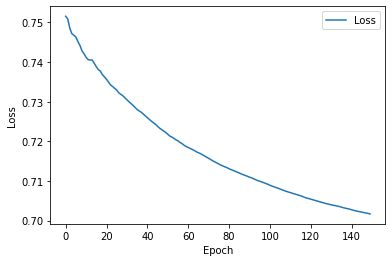

In [30]:
	# plot training history
	plot_training_history(epochs, [train_mean_losses], ylabel='Loss', name='training-loss')

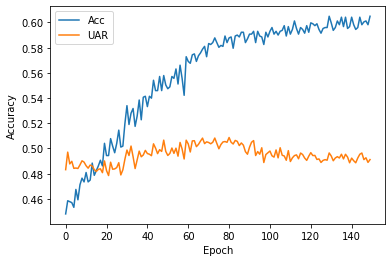

In [31]:
	plot_training_history(epochs, [valid_accs, valid_uar], ylabel='Accuracy', name='validation-metrics')